In [1]:
!pip install requests python-chess tdm matplotlib

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.1/6.1 MB 128.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for tdm: filename=tdm-0.1.0-py3-none-any.whl size=36753 sha256=498f3ddb643a296e04053ada990b6d97244543e79f666eead34c540a4b0a5cf1
  Stored in directory: /root/.cache/pip/wheels/8e/37/3a/bd3858a222edee1cfd475f0b7e0806b2d3789ebe0b738e49af
  Created wheel for chess: filename=chess-1.11.2-py3-none-any.whl size=147775 sha256=0e85d5c3a45b9ea18e872cbfc06174238086e3ca88017bf2fb73dbd094170391
  Stored in directory: /root/.cache/pip/wheels/fb/5d/5c/59a62d8a695285e59ec9c1f66add6f8a9ac4152499a2be0113
Successfully built tdm chess


Using device: cuda

--- Populating Replay Buffer with 1000 Expert Games ---
Attempting to download 1000 blitz game(s) for user: DrNykterstein
  No bz2 Content-Encoding detected. Writing directly...
Successfully downloaded PGN to: magnus_carlsen_blitz_1000_games.pgn

--- Game Information ---
Event: Online League SuperBlitz Arena
Site: https://lichess.org/IyFe2k8U
Date: 2024.03.24
White: Gvein (Elo: 2436)
Black: DrNykterstein (Elo: 3130)
Result: 0-1
ECO (Opening): A36
TimeControl: 180+0
Termination: Normal
--------------------
Failed to download expert games. Replay buffer will not be pre-populated.
Replay buffer size after expert data: 0

--- Starting DQN self-play training ---
Target network updated.
Target network updated.
Episode 1/500, Total Reward: 0.00, Moves: 100, Epsilon: 0.9960, Avg Loss: 0.0000
Target network updated.
Target network updated.
Target network updated.
Target network updated.
Target network updated.
Target network updated.
Target network updated.
Target network up

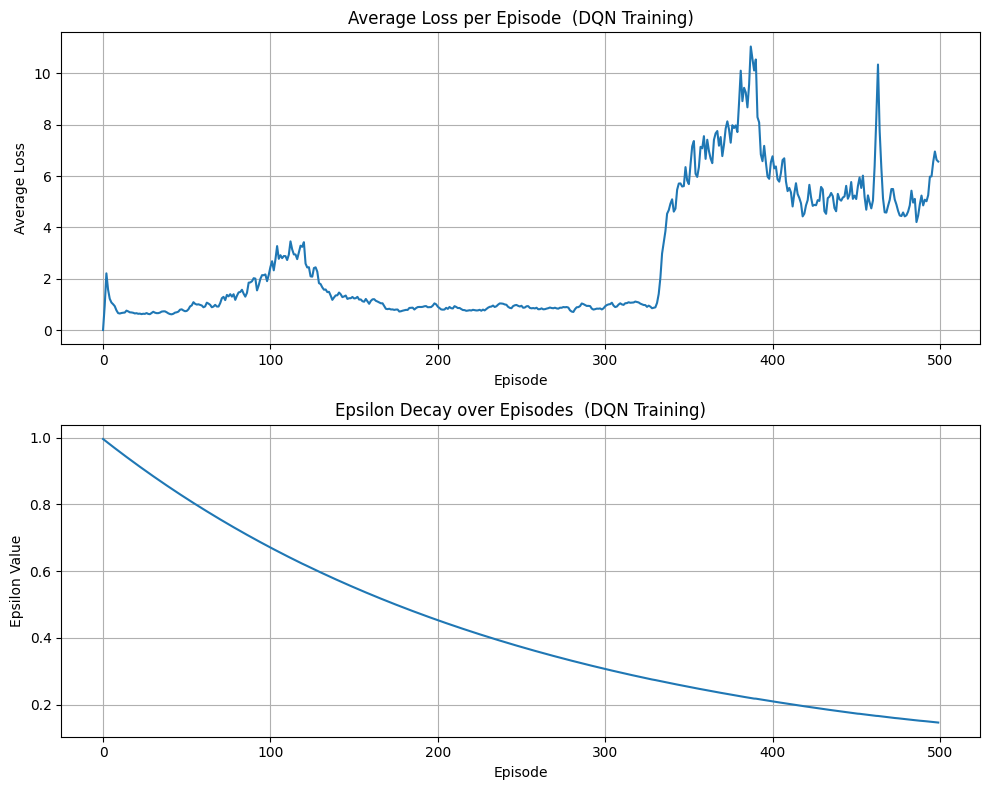

In [2]:
import chess
import chess.pgn
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from collections import deque, namedtuple
import random
import os
import bz2
import requests
import matplotlib.pyplot as plt


QUEEN_DIR_OFFSETS = [
    (0, 1), (1, 1), (1, 0), (1, -1),
    (0, -1), (-1, -1), (-1, 0), (-1, 1)
]
QUEEN_LIKE_MOVES_PLANES = 56

KNIGHT_MOVES_OFFSETS = [
    (1, 2), (2, 1), (2, -1), (1, -2),
    (-1, -2), (-2, -1), (-2, 1), (-1, 2)
] 
KNIGHT_MOVES_PLANES = 8

PAWN_PROMOTION_TYPES = [
    (0, 1),   
    (-1, 1),  
    (1, 1)    
]
PROMOTION_PIECES_ORDER = [chess.QUEEN, chess.ROOK, chess.BISHOP] 
PAWN_PROMOTION_PLANES = 9 

TOTAL_ACTION_PLANES = QUEEN_LIKE_MOVES_PLANES + KNIGHT_MOVES_PLANES + PAWN_PROMOTION_PLANES 
POLICY_OUTPUT_SIZE = TOTAL_ACTION_PLANES * 64 


def download_magnus_carlsen_game(username: str, max_games: int = 1, perf_type: str = None, output_filename: str = "games.pgn"):
    
    print(f"Attempting to download {max_games} {perf_type if perf_type else 'any'} game(s) for user: {username}")
    url = f"https://lichess.org/api/games/user/{username}"
    params = {
        'max': max_games,
        'perfType': perf_type,
        'moves': 1, 
        'pgnInJson': 0, 
        'clocks': 0, 
        'evals': 0, 
        'opening': 0,
        'sort': 'dateDesc' 
    }

    headers = {
        'Accept': 'application/x-chess-pgn',
        'User-Agent': 'YourChessEngineProject/1.0 (contact@example.com)' 
    }

    try:
        response = requests.get(url, params=params, headers=headers, stream=True)
        response.raise_for_status() 

        content_encoding = response.headers.get('Content-Encoding', '')
        output_filepath = output_filename

        with open(output_filepath, 'wb') as f:
            if 'bz2' in content_encoding:
                print("  Content-Encoding: bz2 detected. Decompressing...")
                decompressor = bz2.BZ2Decompressor()
                for chunk in response.iter_content(chunk_size=8192):
                    if chunk:
                        try:
                            f.write(decompressor.decompress(chunk))
                        except bz2.BZ2Error as e:
                            print(f"Error decompressing BZ2 data: {e}. The downloaded file might be corrupted or not valid BZ2.")
                            os.remove(output_filepath)
                            raise
            else:
                print("  No bz2 Content-Encoding detected. Writing directly...")
                for chunk in response.iter_content(chunk_size=8192):
                    if chunk:
                        f.write(chunk)

        if os.path.exists(output_filepath) and os.path.getsize(output_filepath) > 0:
            print(f"Successfully downloaded PGN to: {output_filepath}")

            try:
                with open(output_filepath, 'r', encoding='utf-8') as pgn_file:
                    game = chess.pgn.read_game(pgn_file)
                    if game:
                        print("\n--- Game Information ---")
                        print(f"Event: {game.headers.get('Event')}")
                        print(f"Site: {game.headers.get('Site')}")
                        print(f"Date: {game.headers.get('Date')}")
                        print(f"White: {game.headers.get('White')} (Elo: {game.headers.get('WhiteElo')})")
                        print(f"Black: {game.headers.get('Black')} (Elo: {game.headers.get('BlackElo')})")
                        print(f"Result: {game.headers.get('Result')}")
                        print(f"ECO (Opening): {game.headers.get('ECO')}")
                        print(f"TimeControl: {game.headers.get('TimeControl')}")
                        print(f"Termination: {game.headers.get('Termination')}")
                        print("-" * 20)
                    else:
                        print(f"No game data found in the downloaded PGN: {output_filepath}. File might be empty or malformed.")
                        os.remove(output_filepath)
            except Exception as e:
                print(f"Error reading downloaded PGN file: {e}. File might be corrupted.")
                os.remove(output_filepath)
        else:
            print(f"Downloaded PGN file is empty or missing: {output_filepath}.")

    except requests.exceptions.RequestException as e:
        print(f"Error downloading PGN: {e}")
    except bz2.BZ2Error as e:
        print(f"Caught a BZ2 decompression error: {e}. This likely means the data wasn't valid BZ2, or the file was corrupted during download.")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")

def encode_board_lc0(board: chess.Board, history: deque) -> np.ndarray:
    
    NUM_HISTORY_FRAMES = 8 
    PLANES_PER_FRAME = 14  
    AUX_PLANES = 7         
    NUM_PLANES = (NUM_HISTORY_FRAMES * PLANES_PER_FRAME) + AUX_PLANES 

    encoded_state = np.zeros((NUM_PLANES, 8, 8), dtype=np.float32)

    piece_plane_map = {
        chess.PAWN: 0, chess.KNIGHT: 1, chess.BISHOP: 2,
        chess.ROOK: 3, chess.QUEEN: 4, chess.KING: 5
    }

    all_boards = list(history) + [board]
    all_boards = all_boards[-NUM_HISTORY_FRAMES:]

    for i, historical_board in enumerate(reversed(all_boards)):
        frame_offset = i * PLANES_PER_FRAME

        for sq in chess.SQUARES:
            piece = historical_board.piece_at(sq)
            if piece:
                plane_idx = piece_plane_map[piece.piece_type]
                if piece.color != historical_board.turn:
                    plane_idx += 6 

                rank = chess.square_rank(sq)
                file = chess.square_file(sq)
                encoded_state[frame_offset + plane_idx, rank, file] = 1

        encoded_state[frame_offset + 12, :, :] = 1 if historical_board.turn == historical_board.turn else 0

        if historical_board.ep_square is not None:
            rank = chess.square_rank(historical_board.ep_square)
            file = chess.square_file(historical_board.ep_square)
            encoded_state[frame_offset + 13, rank, file] = 1

    aux_offset = NUM_HISTORY_FRAMES * PLANES_PER_FRAME

    if board.has_kingside_castling_rights(chess.WHITE):
        encoded_state[aux_offset + 0, :, :] = 1
    if board.has_queenside_castling_rights(chess.WHITE):
        encoded_state[aux_offset + 1, :, :] = 1
    if board.has_kingside_castling_rights(chess.BLACK):
        encoded_state[aux_offset + 2, :, :] = 1
    if board.has_queenside_castling_rights(chess.BLACK):
        encoded_state[aux_offset + 3, :, :] = 1

    encoded_state[aux_offset + 4, :, :] = board.halfmove_clock / 100.0

    encoded_state[aux_offset + 5, :, :] = board.fullmove_number / 200.0

    if board.is_repetition():
        encoded_state[aux_offset + 6, :, :] = 1

    
    if board.turn == chess.BLACK:
        encoded_state = np.rot90(encoded_state, k=2, axes=(1, 2)).copy()

        for i in range(NUM_HISTORY_FRAMES):
            frame_offset = i * PLANES_PER_FRAME
            for j in range(6):
                temp = np.copy(encoded_state[frame_offset + j, :, :]) 
                encoded_state[frame_offset + j, :, :] = encoded_state[frame_offset + j + 6, :, :] 
                encoded_state[frame_offset + j + 6, :, :] = temp

        temp = np.copy(encoded_state[aux_offset + 0, :, :]) 
        encoded_state[aux_offset + 0, :, :] = encoded_state[aux_offset + 2, :, :] 
        encoded_state[aux_offset + 2, :, :] = temp

        temp = np.copy(encoded_state[aux_offset + 1, :, :]) 
        encoded_state[aux_offset + 1, :, :] = encoded_state[aux_offset + 3, :, :] 
        encoded_state[aux_offset + 3, :, :] = temp

    return encoded_state

def get_action_plane_idx_lc0(move: chess.Move, board: chess.Board) -> int:
    
    from_sq = move.from_square
    to_sq = move.to_square

    if board.turn == chess.BLACK:
        from_sq = chess.square_mirror(from_sq)
        to_sq = chess.square_mirror(to_sq)

    from_rank, from_file = chess.square_rank(from_sq), chess.square_file(from_sq)
    to_rank, to_file = chess.square_rank(to_sq), chess.square_file(to_sq)

    dx = to_file - from_file 
    dy = to_rank - from_rank 

    if move.promotion:
        try:
            promotion_piece_idx = PROMOTION_PIECES_ORDER.index(move.promotion)
        except ValueError:
            if move.promotion == chess.KNIGHT:
                promotion_piece_idx = PROMOTION_PIECES_ORDER.index(chess.QUEEN)
            else:
                raise ValueError(f"Unexpected promotion piece: {move.promotion} in move {move.uci()}")

        if dx == 0: 
            pawn_move_type_idx = 0
        elif dx == -1: 
            pawn_move_type_idx = 1
        elif dx == 1: 
            pawn_move_type_idx = 2
        else:
            raise ValueError(f"Invalid pawn promotion dx: {dx} for move {move.uci()}")

        action_plane_idx = QUEEN_LIKE_MOVES_PLANES + KNIGHT_MOVES_PLANES + \
                           (promotion_piece_idx * 3) + pawn_move_type_idx
        return action_plane_idx

    knight_move_delta = (dx, dy)
    if knight_move_delta in KNIGHT_MOVES_OFFSETS:
        action_plane_idx = QUEEN_LIKE_MOVES_PLANES + KNIGHT_MOVES_OFFSETS.index(knight_move_delta)
        return action_plane_idx

    abs_dx = abs(dx)
    abs_dy = abs(dy)

    if (abs_dx == 0 and abs_dy > 0) or \
       (abs_dy == 0 and abs_dx > 0) or \
       (abs_dx == abs_dy and abs_dx > 0):

        distance = max(abs_dx, abs_dy)
        if distance == 0 or distance > 7:
            raise ValueError(f"Invalid distance {distance} for ray move: {move.uci()}")

        norm_dx = dx // distance if distance > 0 else 0
        norm_dy = dy // distance if distance > 0 else 0

        try:
            direction_idx = QUEEN_DIR_OFFSETS.index((norm_dx, norm_dy))
        except ValueError:
            raise ValueError(f"Invalid direction for ray move: {move.uci()} (dx={dx}, dy={dy})")

        action_plane_idx = direction_idx * 7 + (distance - 1)
        return action_plane_idx

    raise ValueError(f"Move {move.uci()} from {board.fen()} does not fit Lc0 action plane scheme.")

def encode_move_lc0_style(move: chess.Move, board: chess.Board) -> int:
    
    from_sq_encoded = move.from_square
    if board.turn == chess.BLACK:
        from_sq_encoded = chess.square_mirror(from_sq_encoded) 

    action_plane_idx = get_action_plane_idx_lc0(move, board)

    return from_sq_encoded * TOTAL_ACTION_PLANES + action_plane_idx

def decode_move_lc0_style(predicted_idx: int, board: chess.Board) -> chess.Move:
    
    from_sq_pred = predicted_idx // TOTAL_ACTION_PLANES
    action_plane_idx_pred = predicted_idx % TOTAL_ACTION_PLANES

    if board.turn == chess.BLACK:
        from_sq_pred = chess.square_mirror(from_sq_pred)

    for legal_move in board.legal_moves:
        try:
            encoded_legal_move_idx = encode_move_lc0_style(legal_move, board)
            if encoded_legal_move_idx == predicted_idx:
                return legal_move
        except ValueError:
            pass

    
    print(f"Warning: No direct legal move found for predicted index {predicted_idx} on board {board.fen()}. Returning random legal move.")
    if board.legal_moves:
        return random.choice(list(board.legal_moves))
    else:
        return None 

class ResidualBlock(nn.Module):
    
    def __init__(self, num_channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(num_channels, num_channels, kernel_size=3, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(num_channels)
        self.conv2 = nn.Conv2d(num_channels, num_channels, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(num_channels)

    def forward(self, x):
        identity = x
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += identity 
        return F.relu(out)

class ChessNet(nn.Module):
    
    def __init__(self, num_residual_blocks=5, num_channels=128):
        super(ChessNet, self).__init__()
        NUM_HISTORY_FRAMES = 8
        PLANES_PER_FRAME = 14
        AUX_PLANES = 7
        NUM_PLANES = (NUM_HISTORY_FRAMES * PLANES_PER_FRAME) + AUX_PLANES 

        self.conv_input = nn.Conv2d(NUM_PLANES, num_channels, kernel_size=3, padding=1, bias=False)
        self.bn_input = nn.BatchNorm2d(num_channels)

        self.res_blocks = nn.ModuleList([ResidualBlock(num_channels) for _ in range(num_residual_blocks)])

        self.policy_conv = nn.Conv2d(num_channels, TOTAL_ACTION_PLANES, kernel_size=1, bias=False)
        self.policy_bn = nn.BatchNorm2d(TOTAL_ACTION_PLANES) 

        self.value_conv = nn.Conv2d(num_channels, 1, kernel_size=1, bias=False)
        self.value_bn = nn.BatchNorm2d(1)
        self.value_fc1 = nn.Linear(1 * 8 * 8, 128) 
        self.value_fc2 = nn.Linear(128, 1) 

    def forward(self, x):
        x = F.relu(self.bn_input(self.conv_input(x)))

        for block in self.res_blocks:
            x = block(x)

        q_values = F.relu(self.policy_bn(self.policy_conv(x)))
        q_values = q_values.view(-1, POLICY_OUTPUT_SIZE) 

        value = F.relu(self.value_bn(self.value_conv(x)))
        value = value.view(-1, 1 * 8 * 8) 
        value = F.relu(self.value_fc1(value))
        value = torch.tanh(self.value_fc2(value)) 

        return q_values, value 

Transition = namedtuple('Transition', ('state', 'action', 'reward', 'next_state', 'done'))

class ReplayBuffer:
    
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity) 

    def push(self, *args):
        """Saves a transition."""
        self.buffer.append(Transition(*args))

    def sample(self, batch_size):
        """Randomly samples a batch of transitions."""
        return random.sample(self.buffer, batch_size)

    def __len__(self):
        """Returns the current size of the buffer."""
        return len(self.buffer)

class DQNAgent:
    
    def __init__(self, q_network, target_network, optimizer, device,
                 gamma=0.99, epsilon_start=1.0, epsilon_end=0.01, epsilon_decay=10000,
                 replay_buffer_capacity=50000, batch_size=256, target_update_freq=100):
        
        self.q_network = q_network.to(device)
        self.target_network = target_network.to(device)
        self.target_network.load_state_dict(self.q_network.state_dict()) 
        self.target_network.eval() 

        self.optimizer = optimizer
        self.device = device
        self.gamma = gamma
        self.epsilon_start = epsilon_start
        self.epsilon_end = epsilon_end
        self.epsilon_decay = epsilon_decay
        self.steps_done = 0 

        self.replay_buffer = ReplayBuffer(replay_buffer_capacity)
        self.batch_size = batch_size
        self.target_update_freq = target_update_freq

        self.history_deque = deque([chess.Board().copy() for _ in range(7)], maxlen=7)

    def get_epsilon(self):
        return self.epsilon_end + (self.epsilon_start - self.epsilon_end) * \
               np.exp(-1. * self.steps_done / self.epsilon_decay)

    def select_action(self, board: chess.Board):
        
        epsilon = self.get_epsilon()
        self.steps_done += 1

        legal_moves = list(board.legal_moves)
        if not legal_moves:
            return None 
        if random.random() < epsilon:
            
            chosen_move = random.choice(legal_moves)
            return chosen_move
        else:
            with torch.no_grad(): 
                encoded_state = encode_board_lc0(board, self.history_deque)
                state_tensor = torch.from_numpy(encoded_state).float().unsqueeze(0).to(self.device)

                q_values_all_actions, _ = self.q_network(state_tensor)

                masked_q_values = torch.full_like(q_values_all_actions, float('-inf'))

                for move in legal_moves:
                    try:
                        encoded_move_idx = encode_move_lc0_style(move, board)
                        masked_q_values[0, encoded_move_idx] = q_values_all_actions[0, encoded_move_idx]
                    except ValueError as e:
                        print(f"Error encoding legal move {move.uci()}: {e}")
                        continue

                predicted_action_idx = torch.argmax(masked_q_values).item()

                chosen_move = decode_move_lc0_style(predicted_action_idx, board)

                if chosen_move is None:
                    print("Warning: decode_move_lc0_style returned None. Choosing random legal move as fallback.")
                    chosen_move = random.choice(legal_moves)

                return chosen_move

    def store_transition(self, state, action, reward, next_state, done):
        
        state_tensor = torch.from_numpy(state).float()
        reward_tensor = torch.tensor([reward], dtype=torch.float32)
        next_state_tensor = torch.from_numpy(next_state).float() if next_state is not None else None
        done_tensor = torch.tensor([done], dtype=torch.bool)
        self.replay_buffer.push(state_tensor, action, reward_tensor, next_state_tensor, done_tensor)

    def update_q_network(self):
        
        if len(self.replay_buffer) < self.batch_size:
            return None 

        transitions = self.replay_buffer.sample(self.batch_size)
        batch = Transition(*zip(*transitions))

        non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), device=self.device, dtype=torch.bool)
        non_final_next_states = torch.stack([s for s in batch.next_state if s is not None]).to(self.device)

        state_batch = torch.stack(batch.state).to(self.device)
        action_batch = torch.tensor(batch.action, dtype=torch.long).unsqueeze(1).to(self.device) 
        reward_batch = torch.cat(batch.reward).to(self.device)

        state_q_values, _ = self.q_network(state_batch)
        state_action_q_values = state_q_values.gather(1, action_batch)

        next_state_q_values = torch.zeros(self.batch_size, device=self.device)
        with torch.no_grad(): 
            if non_final_next_states.size(0) > 0:
                next_state_q_values[non_final_mask], _ = self.target_network(non_final_next_states)[0].max(1)

        expected_state_action_q_values = (next_state_q_values * self.gamma) + reward_batch

        criterion = nn.SmoothL1Loss()
        loss = criterion(state_action_q_values, expected_state_action_q_values.unsqueeze(1)) 

        self.optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_value_(self.q_network.parameters(), 100)
        self.optimizer.step()

        return loss.item()

    def update_target_network(self):
        self.target_network.load_state_dict(self.q_network.state_dict())
        print("Target network updated.")

def populate_replay_buffer_with_expert_data(replay_buffer: ReplayBuffer,
                                            pgn_filepath: str,
                                            num_expert_games: int = 1000,
                                            max_moves_per_game: int = 200):
    
    print(f"\n--- Populating Replay Buffer with {num_expert_games} Expert Games ---")

    if not os.path.exists(pgn_filepath) or os.path.getsize(pgn_filepath) == 0:
        print(f"Downloading {num_expert_games} games...")
        success = download_magnus_carlsen_game(
            username="DrNykterstein",
            max_games=num_expert_games,
            perf_type="blitz",
            output_filename=pgn_filepath
        )
        if not success:
            print("Failed to download expert games. Replay buffer will not be pre-populated.")
            return

    transitions_added = 0
    try:
        with open(pgn_filepath, 'r', encoding='utf-8') as pgn_file:
            game_count = 0
            while True:
                game = chess.pgn.read_game(pgn_file)
                if game is None:
                    break
                game_count += 1
                if game_count % 100 == 0:
                    print(f"  Processing game {game_count}...")

                board = game.board()
                history_deque = deque([board.copy() for _ in range(7)], maxlen=7)

                result = game.headers.get("Result")
                if result == "1-0":
                    final_white_value = 1.0
                    final_black_value = -1.0
                elif result == "0-1":
                    final_white_value = -1.0
                    final_black_value = 1.0
                else:
                    final_white_value = 0.0
                    final_black_value = 0.0

                move_count = 0
                for move in game.mainline_moves():
                    if move_count >= max_moves_per_game:
                        break

                    current_state_tensor = torch.from_numpy(encode_board_lc0(board, history_deque)).float()

                    try:
                        action_encoded_idx = encode_move_lc0_style(move, board)
                    except ValueError:
                        print(f"Warning: Could not encode expert move {move.uci()} for game {game.headers.get('Event')}. Skipping this transition.")
                        board.push(move) 
                        history_deque.append(board.copy())
                        move_count += 1
                        continue

                    reward = 0.0
                    if board.turn == chess.WHITE:
                        reward = final_white_value
                    else:
                        reward = final_black_value

                    board.push(move) 
                    history_deque.append(board.copy()) 

                    done = board.is_game_over()
                    next_state_tensor = torch.from_numpy(encode_board_lc0(board, history_deque)).float() if not done else None


                    replay_buffer.push(current_state_tensor, action_encoded_idx, torch.tensor([reward], dtype=torch.float32), next_state_tensor, torch.tensor([done], dtype=torch.bool))
                    transitions_added += 1
                    move_count += 1

    except Exception as e:
        print(f"Error processing PGN for buffer population: {e}")

    print(f"Finished populating buffer. Added {transitions_added} expert transitions.")

def plot_metrics(episode_losses, episode_epsilons, title_suffix=""):
    """Plots the average loss and epsilon decay over training episodes."""
    fig, axs = plt.subplots(2, 1, figsize=(10, 8))

    axs[0].plot(episode_losses)
    axs[0].set_title(f"Average Loss per Episode {title_suffix}")
    axs[0].set_xlabel("Episode")
    axs[0].set_ylabel("Average Loss")
    axs[0].grid(True)

    axs[1].plot(episode_epsilons)
    axs[1].set_title(f"Epsilon Decay over Episodes {title_suffix}")
    axs[1].set_xlabel("Episode")
    axs[1].set_ylabel("Epsilon Value")
    axs[1].grid(True)

    plt.tight_layout()
    plt.show()


def train_dqn_agent(num_episodes=1000, max_moves_per_game=200, populate_expert_buffer=True):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    q_network = ChessNet(num_residual_blocks=5, num_channels=128)
    target_network = ChessNet(num_residual_blocks=5, num_channels=128)
    optimizer = torch.optim.Adam(q_network.parameters(), lr=0.0001)

    agent = DQNAgent(q_network, target_network, optimizer, device,
                     epsilon_decay=num_episodes * max_moves_per_game / 2,
                     replay_buffer_capacity=100000,
                     batch_size=128,
                     target_update_freq=50)

    if populate_expert_buffer:
        populate_replay_buffer_with_expert_data(
            replay_buffer=agent.replay_buffer,
            pgn_filepath="magnus_carlsen_blitz_1000_games.pgn", 
            num_expert_games=1000,
            max_moves_per_game=100 
        )
        print(f"Replay buffer size after expert data: {len(agent.replay_buffer)}")

    episode_losses = []
    episode_epsilons = []
    log_interval = 10 
    print("\n--- Starting DQN self-play training ---")
    for episode in range(num_episodes):
        board = chess.Board()
        agent.history_deque = deque([board.copy() for _ in range(7)], maxlen=7)
        done = False
        total_reward = 0
        moves_made = 0
        episode_loss = 0
        updates_made = 0

        while not done and moves_made < max_moves_per_game:
            current_player_color = board.turn

            current_state_encoded = encode_board_lc0(board, agent.history_deque)

            action_move = agent.select_action(board)

            if action_move is None:
                done = True
                reward = 0
                print(f"Episode {episode+1}: Game ended due to no legal moves (board: {board.fen()}).")
                break

            action_encoded_idx = encode_move_lc0_style(action_move, board)

            board.push(action_move)
            agent.history_deque.append(board.copy())

            reward = 0.0
            if board.is_checkmate():
                if board.turn == chess.BLACK:
                    reward = 1.0 if current_player_color == chess.WHITE else -1.0
                else:
                    reward = 1.0 if current_player_color == chess.BLACK else -1.0
                done = True
            elif board.is_stalemate() or board.is_insufficient_material() or board.is_fivefold_repetition() or board.is_seventyfive_moves():
                reward = 0.0
                done = True

            next_state_encoded = encode_board_lc0(board, agent.history_deque) if not done else None

            agent.store_transition(current_state_encoded, action_encoded_idx, reward, next_state_encoded, done)

            loss = agent.update_q_network()
            if loss is not None:
                episode_loss += loss
                updates_made += 1

            total_reward += reward
            moves_made += 1

            if agent.steps_done % agent.target_update_freq == 0:
                agent.update_target_network()

        avg_episode_loss = episode_loss / updates_made if updates_made > 0 else 0
        episode_losses.append(avg_episode_loss)
        episode_epsilons.append(agent.get_epsilon())
        if episode % 10 == 0:
            print(f"Episode {episode+1}/{num_episodes}, Total Reward: {total_reward:.2f}, Moves: {moves_made}, Epsilon: {agent.get_epsilon():.4f}, Avg Loss: {avg_episode_loss:.4f}")

    print("DQN Training complete!")
    torch.save(q_network.state_dict(), "dqn_chess_agent_final.pth")
    print("Final DQN Agent saved to dqn_chess_agent_final.pth")
    plot_metrics(episode_losses, episode_epsilons, title_suffix=" (DQN Training)")


if __name__ == "__main__":
    train_dqn_agent(num_episodes=500, max_moves_per_game=100) 